# Imports

In [1]:
import sys, os

try:
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    # Fallback for Jupyter/interactive mode
    project_root = os.path.abspath("..")

if project_root not in sys.path:
    sys.path.append(project_root)

# Standard library imports
import random

# Third-party imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt

# Local imports
from src.models.vit_wrapper import ViTModel
from src.models.vgg import VGGWrapper
from src.data.dataset_wrapper import PACSDataset
from src.utils.trainer import Trainer
from src.utils.configuration import (
    DEVICE, SEED, BATCH_SIZE, NUM_EPOCHS,
    NUM_CLASSES, DATA_ROOT, DOMAINS, MODELS
)

Device: cuda


# ViT Base

## Leave-One-Domain-Out (LODO) Training

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:

results_base = {}

for test_domain in DOMAINS:
    print(f"\nTesting on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_base = ViTModel(NUM_CLASSES, model_size="base")
    optimizer = optim.Adam(model_base.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_base, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_base = trainer.train(train_loader)
        val_acc_base = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_base:.4f} | Val Acc: {val_acc_base:.4f}")

    # Test
    test_acc_base = trainer.evaluate(test_loader)
    results_base[test_domain] = test_acc_base
    print(f"Test Accuracy on {test_domain}: {test_acc_base:.4f}")

In [3]:
results_vgg = {}
DATA_ROOT = "/mnt/truenas_smb/pacs_data/pacs_data"

# ---------------- LODO (Leave-One-Domain-Out) ----------------
for test_domain in DOMAINS:
    print(f"\n===== VGG11 LODO: Testing on domain: {test_domain} =====")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load dataset
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, loss
    model_vgg = VGGWrapper(NUM_CLASSES, pretrained=True)
    optimizer = optim.Adam(model_vgg.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_vgg, optimizer, criterion)

    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f"[VGG11-LODO] Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss = trainer.train(train_loader)
        val_acc = trainer.evaluate(val_loader)
        print(f"[VGG11-LODO] Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Test on the left-out domain
    test_acc = trainer.evaluate(test_loader)
    results_vgg[test_domain] = test_acc
    print(f"[VGG11-LODO] Test Accuracy on {test_domain}: {test_acc:.4f}")


# ---------------- Baseline: Train on ALL domains ----------------
print("\n===== VGG11 Baseline: Training on ALL domains =====")

# Load dataset with all domains
dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
train_loaders = [dataset.get_dataloader(d, train=True) for d in DOMAINS]
val_loaders = [dataset.get_dataloader(d, train=False) for d in DOMAINS]

train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# Model
baseline_model = VGGWrapper(NUM_CLASSES, pretrained=True)
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(baseline_model, optimizer, criterion)

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"[VGG11-Baseline] Epoch {epoch + 1}/{NUM_EPOCHS}")
    train_loss = trainer.train(train_loader)
    val_acc = trainer.evaluate(val_loader)
    print(f"[VGG11-Baseline] Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

# Final eval on all domains combined
baseline_acc = trainer.evaluate(val_loader)
print(f"[VGG11-Baseline] Final Accuracy (all domains): {baseline_acc:.4f}")


# ---------------- Final Results ----------------
print("\n===== Final Results =====")
print("VGG11 LODO Accuracies:", results_vgg)
print("VGG11 Baseline Accuracy (all domains):", baseline_acc)



===== VGG11 LODO: Testing on domain: art_painting =====


[VGG11-LODO] Epoch 1/5


100%|██████████| 265/265 [01:05<00:00,  4.02it/s]



[VGG11-LODO] Train Loss: 0.5783 | Val Acc: 0.8748
[VGG11-LODO] Epoch 2/5


100%|██████████| 265/265 [01:05<00:00,  4.05it/s]



[VGG11-LODO] Train Loss: 0.1938 | Val Acc: 0.9201
[VGG11-LODO] Epoch 3/5


100%|██████████| 265/265 [00:57<00:00,  4.57it/s]



[VGG11-LODO] Train Loss: 0.0913 | Val Acc: 0.9056
[VGG11-LODO] Epoch 4/5


100%|██████████| 265/265 [01:00<00:00,  4.42it/s]



[VGG11-LODO] Train Loss: 0.0506 | Val Acc: 0.9106
[VGG11-LODO] Epoch 5/5


100%|██████████| 265/265 [01:03<00:00,  4.16it/s]


[VGG11-LODO] Train Loss: 0.0385 | Val Acc: 0.9276
[VGG11-LODO] Test Accuracy on art_painting: 0.6512

===== VGG11 LODO: Testing on domain: cartoon =====
[VGG11-LODO] Test Accuracy on art_painting: 0.6512

===== VGG11 LODO: Testing on domain: cartoon =====
[VGG11-LODO] Epoch 1/5
[VGG11-LODO] Epoch 1/5


100%|██████████| 255/255 [00:58<00:00,  4.40it/s]


[VGG11-LODO] Train Loss: 0.6299 | Val Acc: 0.8804
[VGG11-LODO] Epoch 2/5


100%|██████████| 255/255 [00:56<00:00,  4.54it/s]



[VGG11-LODO] Train Loss: 0.1940 | Val Acc: 0.9124
[VGG11-LODO] Epoch 3/5


100%|██████████| 255/255 [01:05<00:00,  3.90it/s]



[VGG11-LODO] Train Loss: 0.0899 | Val Acc: 0.9085
[VGG11-LODO] Epoch 4/5


100%|██████████| 255/255 [00:57<00:00,  4.40it/s]



[VGG11-LODO] Train Loss: 0.0701 | Val Acc: 0.9209
[VGG11-LODO] Epoch 5/5


100%|██████████| 255/255 [00:53<00:00,  4.73it/s]



[VGG11-LODO] Train Loss: 0.0457 | Val Acc: 0.9144
[VGG11-LODO] Test Accuracy on cartoon: 0.6823

===== VGG11 LODO: Testing on domain: photo =====
[VGG11-LODO] Test Accuracy on cartoon: 0.6823

===== VGG11 LODO: Testing on domain: photo =====
[VGG11-LODO] Epoch 1/5
[VGG11-LODO] Epoch 1/5


100%|██████████| 278/278 [00:57<00:00,  4.86it/s]



[VGG11-LODO] Train Loss: 0.6889 | Val Acc: 0.8012
[VGG11-LODO] Epoch 2/5


100%|██████████| 278/278 [01:30<00:00,  3.07it/s]



[VGG11-LODO] Train Loss: 0.2340 | Val Acc: 0.8997
[VGG11-LODO] Epoch 3/5


100%|██████████| 278/278 [01:01<00:00,  4.49it/s]



[VGG11-LODO] Train Loss: 0.0923 | Val Acc: 0.8583
[VGG11-LODO] Epoch 4/5


100%|██████████| 278/278 [00:56<00:00,  4.96it/s]



[VGG11-LODO] Train Loss: 0.0669 | Val Acc: 0.9039
[VGG11-LODO] Epoch 5/5


100%|██████████| 278/278 [00:56<00:00,  4.91it/s]



[VGG11-LODO] Train Loss: 0.0567 | Val Acc: 0.9033
[VGG11-LODO] Test Accuracy on photo: 0.9222

===== VGG11 LODO: Testing on domain: sketch =====
[VGG11-LODO] Test Accuracy on photo: 0.9222

===== VGG11 LODO: Testing on domain: sketch =====
[VGG11-LODO] Epoch 1/5
[VGG11-LODO] Epoch 1/5


100%|██████████| 203/203 [00:41<00:00,  4.90it/s]



[VGG11-LODO] Train Loss: 0.5901 | Val Acc: 0.8755
[VGG11-LODO] Epoch 2/5


100%|██████████| 203/203 [00:41<00:00,  4.90it/s]



[VGG11-LODO] Train Loss: 0.1753 | Val Acc: 0.8945
[VGG11-LODO] Epoch 3/5


100%|██████████| 203/203 [00:42<00:00,  4.75it/s]



[VGG11-LODO] Train Loss: 0.1048 | Val Acc: 0.9110
[VGG11-LODO] Epoch 4/5


100%|██████████| 203/203 [00:42<00:00,  4.75it/s]



[VGG11-LODO] Train Loss: 0.0453 | Val Acc: 0.9308
[VGG11-LODO] Epoch 5/5


100%|██████████| 203/203 [00:46<00:00,  4.38it/s]



[VGG11-LODO] Train Loss: 0.0200 | Val Acc: 0.8912
[VGG11-LODO] Test Accuracy on sketch: 0.4580

===== VGG11 Baseline: Training on ALL domains =====
[VGG11-LODO] Test Accuracy on sketch: 0.4580

===== VGG11 Baseline: Training on ALL domains =====
[VGG11-Baseline] Epoch 1/5
[VGG11-Baseline] Epoch 1/5


100%|██████████| 333/333 [01:16<00:00,  4.35it/s]



[VGG11-Baseline] Train Loss: 0.6637 | Val Acc: 0.8809
[VGG11-Baseline] Epoch 2/5


100%|██████████| 333/333 [01:13<00:00,  4.52it/s]


[VGG11-Baseline] Train Loss: 0.1957 | Val Acc: 0.9030
[VGG11-Baseline] Epoch 3/5


100%|██████████| 333/333 [01:10<00:00,  4.71it/s]



[VGG11-Baseline] Train Loss: 0.1095 | Val Acc: 0.8859
[VGG11-Baseline] Epoch 4/5


100%|██████████| 333/333 [01:09<00:00,  4.78it/s]



[VGG11-Baseline] Train Loss: 0.0528 | Val Acc: 0.8779
[VGG11-Baseline] Epoch 5/5


100%|██████████| 333/333 [01:01<00:00,  5.38it/s]



[VGG11-Baseline] Train Loss: 0.0562 | Val Acc: 0.9180
[VGG11-Baseline] Final Accuracy (all domains): 0.9180

===== Final Results =====
VGG11 LODO Accuracies: {'art_painting': 0.651219512195122, 'cartoon': 0.6823027718550106, 'photo': 0.9221556886227545, 'sketch': 0.4580152671755725}
VGG11 Baseline Accuracy (all domains): 0.9179589794897449
[VGG11-Baseline] Final Accuracy (all domains): 0.9180

===== Final Results =====
VGG11 LODO Accuracies: {'art_painting': 0.651219512195122, 'cartoon': 0.6823027718550106, 'photo': 0.9221556886227545, 'sketch': 0.4580152671755725}
VGG11 Baseline Accuracy (all domains): 0.9179589794897449


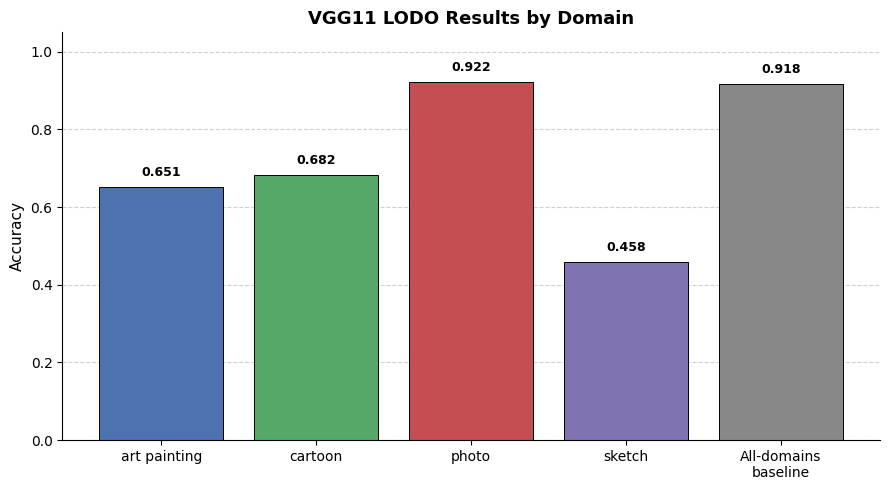

In [4]:
import matplotlib.pyplot as plt

# Data
results = {
    "art_painting": 0.6512,
    "cartoon": 0.6823,
    "photo": 0.9222,
    "sketch": 0.4580,
    "All-domains baseline": 0.9180
}

# Prepare labels & values
labels = []
values = []
for k, v in results.items():
    if "All-domains" in k:
        labels.append("All-domains\nbaseline")
    else:
        labels.append(k.replace("_", " "))
    values.append(v)

# Plot
fig, ax = plt.subplots(figsize=(9, 5))
x = range(len(labels))

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#888888"]
bars = ax.bar(x, values, color=colors, edgecolor="black", linewidth=0.7)

# Axis & labels
ax.set_ylim(0, 1.05)
ax.set_ylabel("Accuracy", fontsize=11)
ax.set_title("VGG11 LODO Results by Domain", fontsize=13, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10, rotation=0, ha="center")

# Grid
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.set_axisbelow(True)

# Annotate values
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="semibold"
    )

# Remove top/right spines
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# fig.savefig("vgg11_lodo_results.png", dpi=300)
plt.show()


## Basline

In [ ]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model_base = ViTModel(NUM_CLASSES, model_size="base")
baseline_optimizer = optim.Adam(baseline_model_base.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_base, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_base = baseline_trainer.train(full_train_loader)
    baseline_val_acc_base = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_base:.4f} | Baseline Acc: {baseline_val_acc_base:.4f}")

# Test baseline
baseline_test_acc_base = baseline_trainer.evaluate(full_test_loader)
results_base['baseline_all_domains'] = baseline_test_acc_base
print(f"Baseline Test Accuracy: {baseline_test_acc_base:.4f}")

## Visual Comparison

In [ ]:
domains = list(results_base.keys())
accuracies = [results_base[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Base)')
plt.tight_layout()
plt.show()

## Final Results

In [ ]:
print("\Final Results (LODO Accuracy):")
for domain, acc in results_base.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_base.values()) / len(results_base)
print(f"\nAverage Accuracy: {avg_acc:.4f}")

---

# WinKawaks/ViT Small

## Leave-One-Domain-Out (LODO) Training

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_small = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_small = ViTModel(NUM_CLASSES, model_size="small")
    optimizer = optim.Adam(model_small.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_small, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_small = trainer.train(train_loader)
        val_acc_small = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_small:.4f} | Val Acc: {val_acc_small:.4f}")

    # Test
    test_acc_small = trainer.evaluate(test_loader)
    results_small[test_domain] = test_acc_small
    print(f"Test Accuracy on {test_domain}: {test_acc_small:.4f}")

## Baseline

In [ ]:
print("\nBaseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
# CORRECTED: Added model_size="small" to ensure the correct model is loaded.
baseline_model_small = ViTModel(NUM_CLASSES, model_size="small")
baseline_optimizer = optim.Adam(baseline_model_small.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_small, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_small = baseline_trainer.train(full_train_loader)
    baseline_val_acc_small = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_small:.4f} | Baseline Acc: {baseline_val_acc_small:.4f}")

# Test baseline
baseline_test_acc_small = baseline_trainer.evaluate(full_test_loader)
results_small['baseline_all_domains'] = baseline_test_acc_small
print(f"Baseline Test Accuracy: {baseline_test_acc_small:.4f}")

## Visual Comparison

In [ ]:
domains = list(results_small.keys())
accuracies = [results_small[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Small)')
plt.tight_layout()
plt.show()

## Final Results

In [ ]:
print("\Final Results (LODO Accuracy):")
for domain, acc in results_small.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_small.values()) / len(results_small)
print(f"\nAverage Accuracy: {avg_acc:.4f}")

---

# WinKawaks/ViT Tiny

## Leave-One-Domain-Out (LODO) Training

In [ ]:
# WinKawaks/ViT Tiny
# Leave-One-Domain-Out (LODO) Training

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_tiny = {}

for test_domain in DOMAINS:
    print(f"\nTesting on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_tiny = ViTModel(NUM_CLASSES, model_size="tiny")
    # CORRECTED: Optimizer now uses parameters from model_tiny, not model_base.
    optimizer = optim.Adam(model_tiny.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_tiny, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_tiny = trainer.train(train_loader)
        val_acc_tiny = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_tiny:.4f} | Val Acc: {val_acc_tiny:.4f}")

    # Test
    test_acc_tiny = trainer.evaluate(test_loader)
    results_tiny[test_domain] = test_acc_tiny
    print(f"Test Accuracy on {test_domain}: {test_acc_tiny:.4f}")

## Baseline

In [ ]:
print("\nBaseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
# CORRECTED: Added model_size="tiny" to ensure the correct model is loaded.
baseline_model_tiny = ViTModel(NUM_CLASSES, model_size="tiny")
baseline_optimizer = optim.Adam(baseline_model_tiny.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_tiny, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_tiny = baseline_trainer.train(full_train_loader)
    baseline_val_acc_tiny = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_tiny:.4f} | Baseline Acc: {baseline_val_acc_tiny:.4f}")

# Test baseline
baseline_test_acc_tiny = baseline_trainer.evaluate(full_test_loader)
results_tiny['baseline_all_domains'] = baseline_test_acc_tiny
print(f"Baseline Test Accuracy: {baseline_test_acc_tiny:.4f}")

## Visual Comparison

In [ ]:
domains = list(results_tiny.keys())
accuracies = [results_tiny[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Tiny)')
plt.tight_layout()
plt.show()

## Final Results

In [ ]:
print("\Final Results (LODO Accuracy):")
for domain, acc in results_tiny.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_tiny.values()) / len(results_tiny)
print(f"\nAverage Accuracy: {avg_acc:.4f}")

---

# Performance Comparison

In [ ]:
plt.figure(figsize=(20, 12))

for idx, domain in enumerate(DOMAINS):
    plt.subplot(2, 3, idx + 1)

    domain_accuracies = [
        results_base[domain],
        results_small[domain],
        results_tiny[domain]
    ]

    bars = plt.bar(MODELS.keys(), domain_accuracies, color=["skyblue", "orange", "green"])
    plt.ylim(0, 1)
    plt.ylabel("Test Accuracy")
    plt.title(f"Model Comparison - {domain} Domain")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    
    # Add value labels on top of bars
    for i, acc in enumerate(domain_accuracies):
        plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

# Create the baseline comparison subplot
plt.subplot(2, 3, 5) 
baseline_accuracies = [
    results_base["baseline_all_domains"],
    results_small["baseline_all_domains"],
    results_tiny["baseline_all_domains"]
]
plt.bar(MODELS.keys(), baseline_accuracies, color=["skyblue", "orange", "green"])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison - Baseline (All Domains)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, acc in enumerate(baseline_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

plt.tight_layout()
plt.show()

print("\nDetailed Performance Comparison:")
print("-" * 60)
print(f"{'Domain':<15} {'Base':>10} {'Small':>10} {'Tiny':>10}")
print("-" * 60)

for domain in DOMAINS:
    print(f"{domain:<15} {results_base[domain]:>10.2%} {results_small[domain]:>10.2%} {results_tiny[domain]:>10.2%}")

print("-" * 60)
print(f"{'Baseline':<15} {results_base['baseline_all_domains']:>10.2%} {results_small['baseline_all_domains']:>10.2%} {results_tiny['baseline_all_domains']:>10.2%}")
print("-" * 60)